In [1]:
#PART 1: preprocessing the dataset using node embedding in the network using node2vec algorithm

#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import itertools
%matplotlib inline

In [2]:
#importing the combined ratings file as a dataframe

short_network = pd.read_csv('/Users/smritisridhar/Desktop/Blockchain-NUS/shorter_network.csv', engine = 'python')
short_network.head()

,SOURCE,TARGET,RATING,TIMESTAMP,EPISODE
0,35,3952,1,1.365623e+09,21958
1,2125,5379,-1,1.392045e+09,32086
2,5227,5854,1,1.417038e+09,35751
3,6013,13492,-1,1.393304e+09,32395
4,6013,13495,-1,1.392008e+09,32075


In [3]:
#function definition to extract node features from the network dataframe

def GetNodeFeatures(GDF,n):
    if n==0:
        return ['in_nodedegree','out_nodedegree','positive_in_edges','negative_in_edges','positive_out_edges','negative_out_edges']
    
    # Get sub-dataframes
    outgoing = GDF[GDF['SOURCE']==n].copy().reset_index(drop=True)
    incoming = GDF[GDF['TARGET']==n].copy().reset_index(drop=True)
    
#creating perception scores as 6 features in addition to feature extraction from Node2vec
    
    # Compute node degree (ratings recieved by the user/node)
    in_nodedegree = len(incoming)
    
    # Compute node degree (ratings given by the user/node)
    out_nodedegree = len(outgoing)
    
    # Compute number of incoming nodes with positive ratings (total positive ratings recieved)
    positive_in_edges = len([i for i in incoming.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings (total negative ratings recieved)
    negative_in_edges = len([i for i in incoming.RATING.values if i<0])
    
    # Computer number of outgoing nodes with negative ratings (total positive ratings given by the user to others)
    positive_out_edges = len([i for i in outgoing.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings (total negative ratings given by the user to others)
    negative_out_edges = len([i for i in outgoing.RATING.values if i<0])
    
    return np.array([in_nodedegree,out_nodedegree,positive_in_edges,negative_in_edges,positive_out_edges,negative_out_edges])

In [4]:
#Obtain node features for all nodes in the shortened network (feature extraction)

# Define list of nodes and sort it in ascending order
nodes = list( set(short_network['SOURCE']) | set(short_network['TARGET']) )
nodes.sort()

# Create NFM, the node feature matrix
NFM = np.zeros([len(nodes),6])
for i,n in enumerate(nodes):
    NFM[i,:] = np.array(GetNodeFeatures(short_network,n))
    
# Create a dataframe containing all these node features
Node_Features_df = pd.DataFrame(columns=GetNodeFeatures(short_network,0),data=NFM,index=nodes)
Node_Features_df.head(1)
Node_Features_df.to_csv('shortnetwork_node_features.csv') 

In [5]:
#reading the node feature file
Node_Features_df = pd.read_csv('shortnetwork_node_features.csv',index_col=0)
Node_Features_df.head(2)

,in_nodedegree,out_nodedegree,positive_in_edges,negative_in_edges,positive_out_edges,negative_out_edges
1,198.0,184.0,198.0,0.0,177.0,7.0
2,36.0,36.0,35.0,1.0,34.0,2.0


In [7]:
#creating an edgelist file from the short network file
f = open('short_network.edgelist', 'w')
for i in range(len(short_network)):
    s = str(short_network['SOURCE'][i])
    t = str(short_network['TARGET'][i])
    f.write(s+' '+t+'\n')
f.close()

In [ ]:
#Run Node2Vec implementation in python for each node in the short_network file for feature learning and embedding



In [6]:
#create a dictionary of node embeddings from the file short_network.emb created from node2vec to get the shape
n = []
e = []
with open('/Users/smritisridhar/Desktop/Blockchain-NUS/short_network.emb') as fin:
    for line in fin:
        node_emb = line.strip().split()
        n.append(node_emb[0])
        e.append(node_emb[1:])
n = n[1:]
n = [int(i) for i in n]
embs = np.zeros([len(e)-1,14])
for i in range(1,len(e)):
    embs[i-1] = e[i]
embs.shape

(9664, 14)

In [7]:
#using dimensionality reduction algorithms like TSNE to create a 2D projections on the embeddings
from sklearn.manifold import TSNE

'''tsne_dimreduction = TSNE(n_components=2, init='pca', random_state=0)
projection = tsne.fit_transform(embs)
np.save('short_network_tSNE_projection.npy',projection)'''

projection = np.load('short_network_tSNE_projection.npy')

In [8]:
#Plot node projections OTC or ALPHA

alpha = [] #for the Bitcoin ALPHA nodes
otc = [] #for the Bitcoin OTC nodes
for i in range(len(n)):
    if n[i] > 6005: # The highest OTC node ID is 6005
        alpha.append(i)
    else:
        otc.append(i)

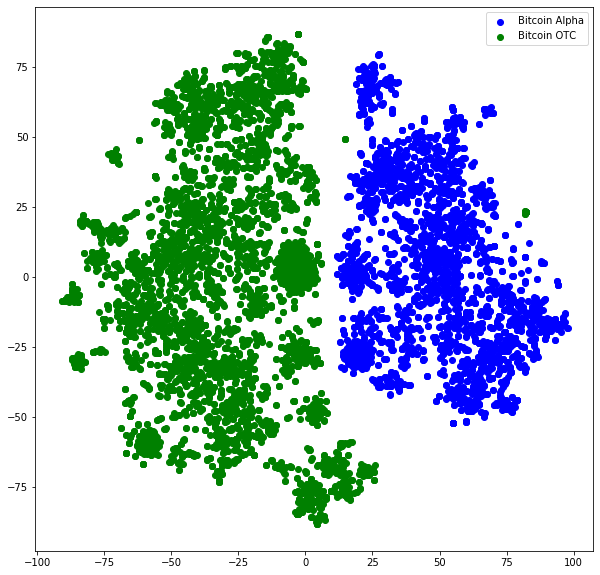

In [44]:
#exploratory data analysis from both the bitcoin markets: BitcoinOTC and BitcoinAlpha

plt.figure(figsize=(10,10))
alpha_projection = projection[alpha,:]
otc_projection = projection[otc,:]
plt.scatter(alpha_projection[:,0],alpha_projection[:,1],c='b',label='Bitcoin Alpha')
plt.scatter(otc_projection[:,0],otc_projection[:,1],c='g',label='Bitcoin OTC')
plt.legend()
plt.savefig('Market_Analysis.png')

In [39]:
#Node2Vec is able to represent nodes in a 14-dimensional space depicting the nodes' neighborhoods. We will expand these node representations by concatenating the 6 node features we calculated earlier so that we get a final 20-dimensional representation for each node.
#this can further be used for link prediction, to know wether a link exists between the nodes or not 


In [11]:
#normalised form of all 20 features

Node_Features_matrix = np.zeros([len(n),20]) # Recall that we have 14 Node2Vec features plus 6 perception features mentioned above extracted from the rating network
for i in range(len(n)):
    Node_Features_matrix[i] = np.concatenate([embs[i],np.log2(Node_Features_df.loc[n[i]].values + 1)])
Node_Features_matrix.shape

(9664, 20)

In [16]:
Node_Features_matrix_mean = np.mean(Node_Features_matrix,axis=0)
Node_Features_matrix_std = np.std(Node_Features_matrix,axis=0)
Node_Features_matrix_norm = ( Node_Features_matrix - Node_Features_matrix_mean ) / ( Node_Features_matrix_std )

In [17]:
#capture the normalised node ID for each feature and putting into a dataframe

norm_node_df = pd.DataFrame(columns=list(range(1,21)),index=n,data=Node_Features_matrix_norm)
norm_node_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
35,-1.774256,-0.448314,0.047397,0.612565,0.797896,-0.789905,-0.051981,-0.121641,-0.866701,0.772711,-0.960294,-0.634862,-0.391693,0.070921,5.995989,5.764529,5.966601,-0.403738,5.928494,5.244485
6006,-0.501574,-0.084692,0.723285,-1.407241,-0.649710,1.117009,0.567946,0.082475,-0.241229,-1.279825,0.483483,-0.937666,-1.084376,0.990163,5.628302,5.253367,5.607510,-0.403738,5.415542,2.245152
2642,-1.139167,-0.513084,1.118884,0.059454,-0.080315,-0.162173,0.315040,0.686051,0.649060,1.255844,-0.181627,0.228191,0.024559,-0.302619,5.577683,5.057479,5.554465,1.132302,5.198008,4.509349
2125,0.168152,0.876179,-0.513470,-0.215777,-0.248220,-0.916373,-0.365312,0.893897,0.826803,0.918575,-0.683717,1.040111,1.754360,-0.239251,4.613721,5.057479,4.616648,-0.403738,4.230008,12.063567
1810,0.072147,0.400560,0.326883,-0.186649,1.174607,-0.715021,-0.125926,1.679218,-0.296529,0.525661,-0.017292,0.255513,0.899269,0.118267,5.310770,5.026762,5.124245,7.598189,4.650978,11.015487


In [38]:
#saving the normalized node embeddings dataframe into a csv file

norm_node_df.to_csv('./short_node_embeddings_mean_normalized.csv')

In [30]:
#norm_node_df = pd.read_csv('short_node_embeddings_normalized.csv',index_col=0)
#norm_node_df = pd.read_csv('short_node_embeddings_normalized_with_log10.csv',index_col=0)
norm_node_df = pd.read_csv('./short_node_embeddings_mean_normalized.csv', index_col=0)

In [31]:
#Create X input matrix and y output vector
#NOTE: Here we assign a score of 1 if transaction is rated badly (fraud), and 0 otherwise
'''Construct the input matrix X and the output vector y. 
Each row of the X matrix contains 40 values (20 values for the source node or buyer, 20 values for the target node or seller).
The y vector captures the rating of the transaction the seller received from the buyer.
'''
import numpy as np

X = np.zeros([len(short_network),40])
y = np.zeros(len(short_network))
for i in range(len(short_network)):
    s = short_network['SOURCE'][i] #source list
    t = short_network['TARGET'][i] #target list
    r = short_network['RATING'][i] #ratings list
    left = norm_node_df.loc[s,:].values
    right = norm_node_df.loc[t,:].values
    X[i,:] = np.concatenate([left,right])
    if r > 0:
        y[i] = 0 # If not fraud
    else:
        y[i] = 1 # If fraud
print(y)

[0. 1. 0. ... 0. 0. 1.]


In [32]:
#Repeat the above procedure for calculating the value of X and value of y from the validation dataframe(Test_network)

validate_network = pd.read_csv('/Users/smritisridhar/Desktop/Blockchain-NUS/Test_network.csv', engine = 'python')
X_val = np.zeros([len(validate_network),40])
y_val = np.zeros(len(validate_network))
for i in range(len(validate_network)):
    s = validate_network['SOURCE'][i]
    t = validate_network['TARGET'][i]
    r = validate_network['RATING'][i]
    left = norm_node_df.loc[s,:].values
    right = norm_node_df.loc[t,:].values
    X_val[i,:] = np.concatenate([left,right])
    if r>0:
        y_val[i] = 0 # If not fraud
    else:
        y_val[i] = 1 # If fraud (class imbalance)
print(y_val)

[0. 0. 0. ... 0. 0. 1.]


In [48]:
#PART 2: Model building: training, testing and evaluation

#Logistic Regression trained with both Node2Vec features and perception scores
#Logistic Regression trained with perception scores only
#Deep Neural Network trained with perception scores only
#Deep Neural Network trained with node2vec and perception scores 
#MLP for binary classification 

In [14]:
# Importing Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#importing deep learning libraries
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers.merge import Concatenate


Using TensorFlow backend.


In [15]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=0)

def CreateSample(frac=0.8): #function to generate samples of training data without biasing it towards the abundant category
    fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==1])
    not_fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==0])
    sample_size = int(np.round( len(fraud_indices) * frac ))
    fraud_sample = np.random.randint(0,len(fraud_indices),sample_size) 
    not_fraud_sample = np.random.randint(0,len(not_fraud_indices),sample_size)
    y_sample = np.concatenate([y_train[fraud_indices][fraud_sample],y_train[not_fraud_indices[not_fraud_sample]]])
    X_sample = np.concatenate([X_train[fraud_indices][fraud_sample],X_train[not_fraud_indices[not_fraud_sample]]])
    return X_sample,y_sample
print(X_train.shape)

(39857, 40)


In [16]:
#function defination to plot a confusion model

from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [7]:
#model 1 : Construct a Neural Net model (without Node2Vec features)

In [17]:
# Initialize model

input_size = 12 # Features from X matrix (only the perception scores)

M1 = Sequential()

# Add an input layer
M1.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M1.add(Dense(128, activation='relu'))

# Add second hidden layer
M1.add(Dense(64, activation='relu'))

#Add third hidden layer
M1.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M1.add(Dense(16, activation='relu'))

# Add output layer
M1.add(Dense(1,activation='sigmoid'))

# Define optimizers

#Nesterov Adam optimizer
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
#SGD optimizer
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M1.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
#cross validation and training using bootstrapping

cols_to_keep = list(range(14,20)) + list(range(34,40)) #without node2vec features using only 6 perception scores
for i in range(15):
    sample_x,sample_y = CreateSample()
    M1.fit(sample_x[:,cols_to_keep], sample_y, epochs=Nepochs, batch_size=5, verbose=0)

Instructions for updating:
Use tf.cast instead.


In [19]:
#evaluating model 1 with test set
y_pred = M1.predict(X_test[:,cols_to_keep])

# Print classfication report
target_names = ['Honest','Fraudulent']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report for Model 1 (NN without Node2Vec)")
print(classification_report(y_test, np.round(y_pred)))

Classification Report for Model 1 (NN without Node2Vec)
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      9119
         1.0       0.59      0.96      0.73       846

    accuracy                           0.94      9965
   macro avg       0.79      0.95      0.85      9965
weighted avg       0.96      0.94      0.95      9965



Model 1
Normalized confusion matrix
[[0.93760281 0.06239719]
 [0.04491726 0.95508274]]


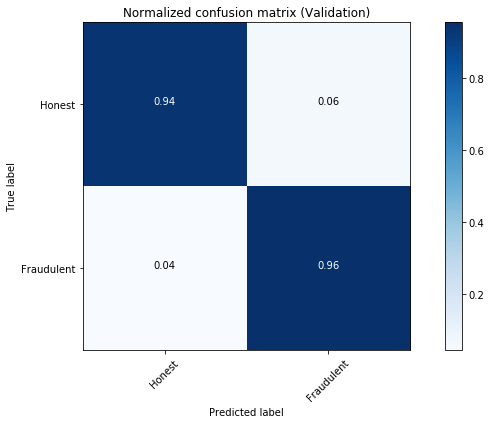

In [20]:
# Plot normalized confusion matrix for model 1 for evaluation

print('Model 1')
plt.figure(figsize=(10,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix (Validation)')

In [ ]:
#construct model 2 (logistic regression using node2vec features and perception scores features created manually)

In [21]:
#train model 2 with training data
M2 = LogisticRegression()
M2.fit(X_train, y_train)

/Users/smritisridhar/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
#evaluate model 2 with testing data
y_pred = M2.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M2.score(X_test, y_test)))

confusion_matrix = cm(y_test, y_pred)
print("Classification Report for Logistic Regression")
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.96
Classification Report for Logistic Regression
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9119
         1.0       0.84      0.66      0.74       846

    accuracy                           0.96      9965
   macro avg       0.90      0.82      0.86      9965
weighted avg       0.96      0.96      0.96      9965



Normalized confusion matrix
[[0.98804693 0.01195307]
 [0.3392435  0.6607565 ]]


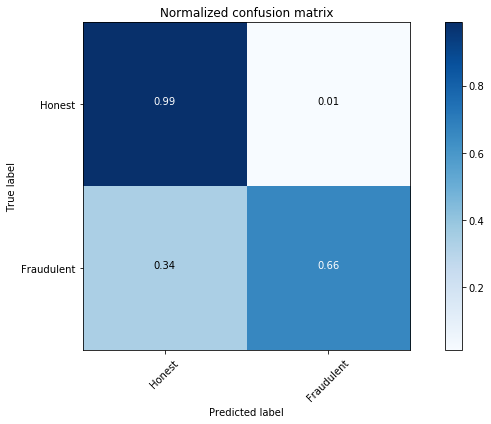

In [23]:
# Plot normalized confusion matrix for model 2 for evaluation
plt.figure(figsize=(10,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
#model 3: Logistic regression with only perception score features (without network features)

In [24]:
M3 = LogisticRegression()
M3.fit(X_train[:,cols_to_keep], y_train)

/Users/smritisridhar/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
#evaluate model 3 with test data
y_pred = M3.predict(X_test[:,cols_to_keep])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M3.score(X_test[:,cols_to_keep], y_test)))

confusion_matrix = cm(y_test, y_pred)
print("Classification Report for Logistic Regression")
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.96
Classification Report for Logistic Regression
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9119
         1.0       0.83      0.62      0.71       846

    accuracy                           0.96      9965
   macro avg       0.90      0.81      0.84      9965
weighted avg       0.95      0.96      0.95      9965



Normalized confusion matrix
[[0.98826626 0.01173374]
 [0.37706856 0.62293144]]


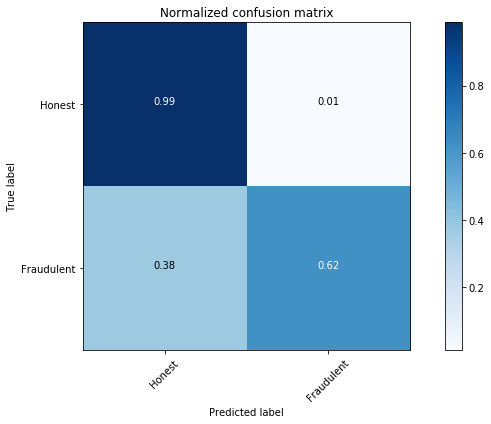

In [28]:
# Plot normalized confusion matrix for model 3 for evaluation
plt.figure(figsize=(10,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

In [33]:
#evaluate model 3 with validation data

y_pred = M3.predict(X_val[:,cols_to_keep])
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(M3.score(X_val[:,cols_to_keep], y_val)))

confusion_matrix = cm(y_val, y_pred)
print("Classification Report for Logistic Regression (Validation)")
print(classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on validation set: 0.94
Classification Report for Logistic Regression (Validation)
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      9075
         1.0       0.73      0.52      0.61       881

    accuracy                           0.94      9956
   macro avg       0.84      0.75      0.79      9956
weighted avg       0.93      0.94      0.94      9956



In [34]:
# model 4: using neural network model with node2vec features and our perception scores features


# Initializing model 4 using tensorflow backend and keras

input_size = 40 # Features from X matrix

M4 = Sequential()

# Add an input layer
M4.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M4.add(Dense(128, activation='relu'))

# Add second hidden layer
M4.add(Dense(64, activation='relu'))

#Add third hidden layer
M4.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M4.add(Dense(16, activation='relu'))

# Add output layer
M4.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M4.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

In [35]:
#training the model by using bootstrapping

for i in range(15):  #using the 14 node2vec features
    sample_x,sample_y = CreateSample() #bootstrapping
    M4.fit(sample_x, sample_y, epochs=Nepochs, batch_size=5, verbose=0)

In [36]:
#evaluate model 4 with test set
y_pred = M4.predict(X_test)

# Print classfication report
target_names = ['Honest','Fraudulent']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report for the NN model (test set)")
print(classification_report(y_test, np.round(y_pred)))

Classification Report for the NN model (test set)
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      9119
         1.0       0.56      0.93      0.70       846

    accuracy                           0.93      9965
   macro avg       0.78      0.93      0.83      9965
weighted avg       0.96      0.93      0.94      9965



Normalized confusion matrix
[[0.93266806 0.06733194]
 [0.07210402 0.92789598]]


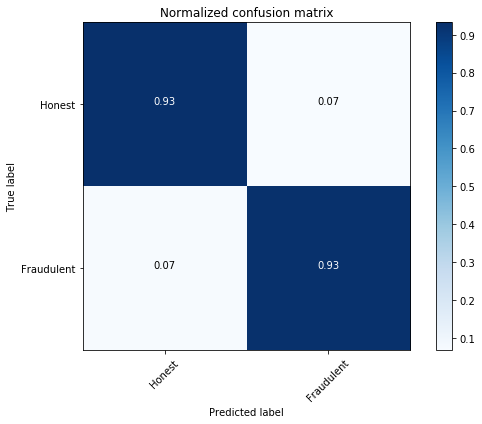

In [37]:
# Plot normalized confusion matrix of model 4 for evaluation 
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

In [38]:
#evaluating with the validation dataset
y_pred = M4.predict(X_val)
# Print confusion matrix
confusion_matrix = cm(y_val, np.round(y_pred))
print("Classification Report for the NN model (Validation set)")
print(classification_report(y_val, np.round(y_pred)))

Classification Report for the NN model (Validation set)
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      9075
         1.0       0.46      0.74      0.57       881

    accuracy                           0.90      9956
   macro avg       0.72      0.83      0.76      9956
weighted avg       0.93      0.90      0.91      9956



In [39]:
#Model 5: MLP for binary classification 

from keras.models import Sequential
from keras.layers import Dense, Dropout


M5 = Sequential()
M5.add(Dense(1, input_dim=40, activation='relu'))
M5.add(Dropout(0.5)) #playing around with the dropout rate
M5.add(Dense(60, activation='relu'))
M5.add(Dropout(0.5))
M5.add(Dense(1, activation='sigmoid'))

M5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = M5.fit(X_train, y_train,
          epochs=5,
          batch_size=10)
score = M5.evaluate(X_test, y_test, batch_size=10)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
39857/39857 [==============================] - 11s 270us/step - loss: 0.3000 - acc: 0.9143
Epoch 2/5
39857/39857 [==============================] - 10s 243us/step - loss: 0.2583 - acc: 0.9154
Epoch 3/5
39857/39857 [==============================] - 9s 236us/step - loss: 0.2550 - acc: 0.9154
Epoch 4/5
39857/39857 [==============================] - 10s 263us/step - loss: 0.2538 - acc: 0.9154
Epoch 5/5
9965/9965 [==============================] - 1s 87us/step


dict_keys(['loss', 'acc'])


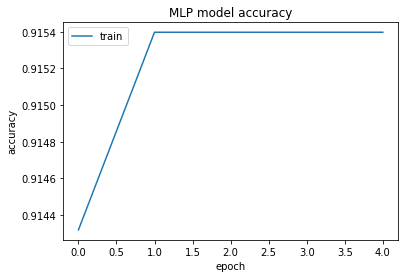

<Figure size 432x288 with 0 Axes>

In [40]:
#visualizing the history of training 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('MLP model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('MLP_model.png')

In [41]:
#model 6: CNN with 1-D classifications 

'''from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

seq_length = 40

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(seq_length, 40)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=16, epochs=5)
score = model.evaluate(X_test, y_test, batch_size=10)'''

"from keras.layers import Dense, Dropout\nfrom keras.layers import Embedding\nfrom keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D\n\nseq_length = 40\n\nmodel = Sequential()\nmodel.add(Conv1D(64, 3, activation='relu', input_shape=(seq_length, 40)))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(MaxPooling1D(3))\nmodel.add(Conv1D(128, 3, activation='relu'))\nmodel.add(Conv1D(128, 3, activation='relu'))\nmodel.add(GlobalAveragePooling1D())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, activation='sigmoid'))\n\nmodel.compile(loss='binary_crossentropy',\n              optimizer='rmsprop',\n              metrics=['accuracy'])\n\nmodel.fit(X_train, y_train, batch_size=16, epochs=5)\nscore = model.evaluate(X_test, y_test, batch_size=10)"

In [ ]:
#PART 3: evaluation and performance

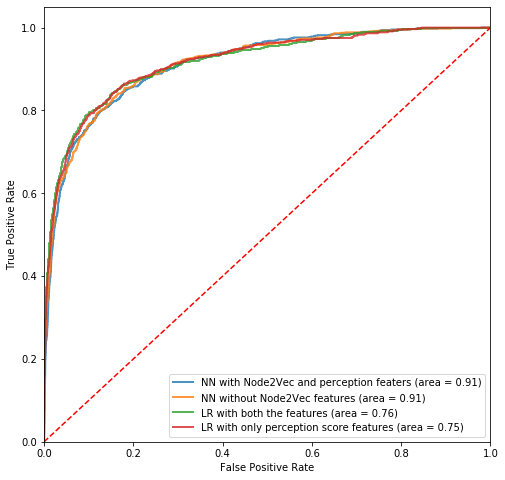

In [42]:
#Plotting ROC curve
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))

logit_roc_auc = roc_auc_score(y_val, M4.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, M4.predict_proba(X_val))
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='NN with Node2Vec and perception featers (area = %0.2f)' % (logit_roc_auc))

logit_roc_auc = roc_auc_score(y_val, M1.predict(X_val[:,cols_to_keep]))
fpr, tpr, thresholds = roc_curve(y_val, M1.predict_proba(X_val[:,cols_to_keep]))
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='NN without Node2Vec features (area = %0.2f)' % (logit_roc_auc))

logit_roc_auc = roc_auc_score(y_val, M2.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, M2.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='LR with both the features (area = %0.2f)' % (logit_roc_auc))

logit_roc_auc = roc_auc_score(y_val, M3.predict(X_val[:,cols_to_keep]))
fpr, tpr, thresholds = roc_curve(y_val, M3.predict_proba(X_val[:,cols_to_keep])[:,1])
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='LR with only perception score features (area = %0.2f)' % (logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")
plt.savefig('ROC_performance.png')


In [78]:
#kfold cross validation 


'''from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# split into input (X) and output (Y) variables
X_1 = X[:,0:8]
y_1 = y[:,]
# define 10-fold cross validation test harness

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_1, y_1):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_1[train], y_1[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_1[test], y_1[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))'''
